# 毕设书
---

## 地图匹配，将充电需求对应在路网图中

1.将充电需求对应在路网图中，路网图为二维平面，充电需求由车辆产生，根据充电需求产生的地址将其对应到路网图中的点，所述点称为需求点。
所述需求点从城市中车辆停留时间较长的位置产生，包括以下信息：充电需求产生的地址、充电需求产生的时间、预估的充电时长和车辆剩余行驶里程。

In [ ]:
'''
#1 —— 一次性执行
#t —— 测试单元，可删除
'''

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.pyplot import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
from scipy.stats import truncnorm
import math
import pickle
import re

In [2]:
# 
data_dir = 'data_test'

随机地图数据（包括地图块类型：小区、办公区、商贸区），地图设置为$1000\times1000$大小，其中住宅区占比：30%，办公区占比：10%,商贸区占比：5%

0-没有需求区域，1-小区，2-办公区，3-商贸区

In [3]:
# 常量定义
map_size = 100 #地图大小
map_step = 20  #划分地图

In [4]:
#1 使用随机直线划分格子
while True:
    map_roll = np.sort(np.unique(np.random.randint(1, map_size, map_step-1)))#划分地图区域
    map_cul = np.sort(np.unique(np.random.randint(1, map_size, map_step-1)))#划分地图区域
    if len(map_cul)==19 and len(map_roll)==19:
        break
print(map_roll.size)
print(map_cul.size)

19
19


In [5]:
#1 写入文件 
np.savetxt(data_dir+'/map_roll.txt', map_roll, fmt='%d', delimiter=',')
np.savetxt(data_dir+'/map_cul.txt', map_cul, fmt='%d', delimiter=',')

In [6]:
# 从文件中读取
map_roll = np.loadtxt(data_dir+'/map_roll.txt', delimiter=',', dtype=int)
map_roll = np.append(map_roll, map_size)
#map_roll = np.insert(map_roll, 0, 0)
map_cul = np.loadtxt(data_dir+'/map_cul.txt', delimiter=',', dtype=int)
#map_cul = np.insert(map_cul, 0, 0)
map_cul = np.append(map_cul, map_size)

In [7]:
#t
print(map_cul)

[  8  11  12  13  16  17  34  35  43  48  49  50  53  54  57  70  73  79
  98 100]


In [8]:
#1 随机区域
map_rate = [0.55, 0.3, 0.1, 0.05]
map_x = np.arange(4)
map_distribution = np.random.choice(a=map_x, size=map_step**2, replace=True, p=map_rate)

In [9]:
#1 将区域信息写入文件
np.savetxt(data_dir+'/map_distribution.txt', map_distribution, fmt='%d', delimiter=',')

In [10]:
# 读取区域
map_distribution = np.loadtxt(data_dir+'/map_distribution.txt', delimiter=',', dtype=int)

In [11]:
#t 看比例
print(sum(map_distribution==0)/map_step**2)
print(sum(map_distribution==1)/map_step**2)
print(sum(map_distribution==2)/map_step**2)
print(sum(map_distribution==3)/map_step**2)

0.5675
0.3
0.0675
0.065


In [12]:
#1 将地图赋值     

mmap = np.ones((map_size,map_size), dtype=np.int) #地图

x_b = 0
y_b = 0
it_mapd = 0
for y_e in map_cul:
    for x_e in map_roll:
        mmap[x_b:x_e, y_b:y_e] *= map_distribution[it_mapd]
        x_b = x_e
        it_mapd += 1
    y_b = y_e

In [13]:
#1 将地图存入文件
np.savetxt(data_dir+'/mmap.txt', mmap, fmt='%d', delimiter=',')

In [10]:
# 读取地图
mmap = np.loadtxt(data_dir+'/mmap.txt', delimiter=',', dtype=int)

In [15]:
#t 查看每种区域的地图占比
print(sum(sum(mmap==0))/map_size**2)
print(sum(sum(mmap==1))/map_size**2)
print(sum(sum(mmap==2))/map_size**2)
print(sum(sum(mmap==3))/map_size**2)

0.5445
0.3302
0.0567
0.0686


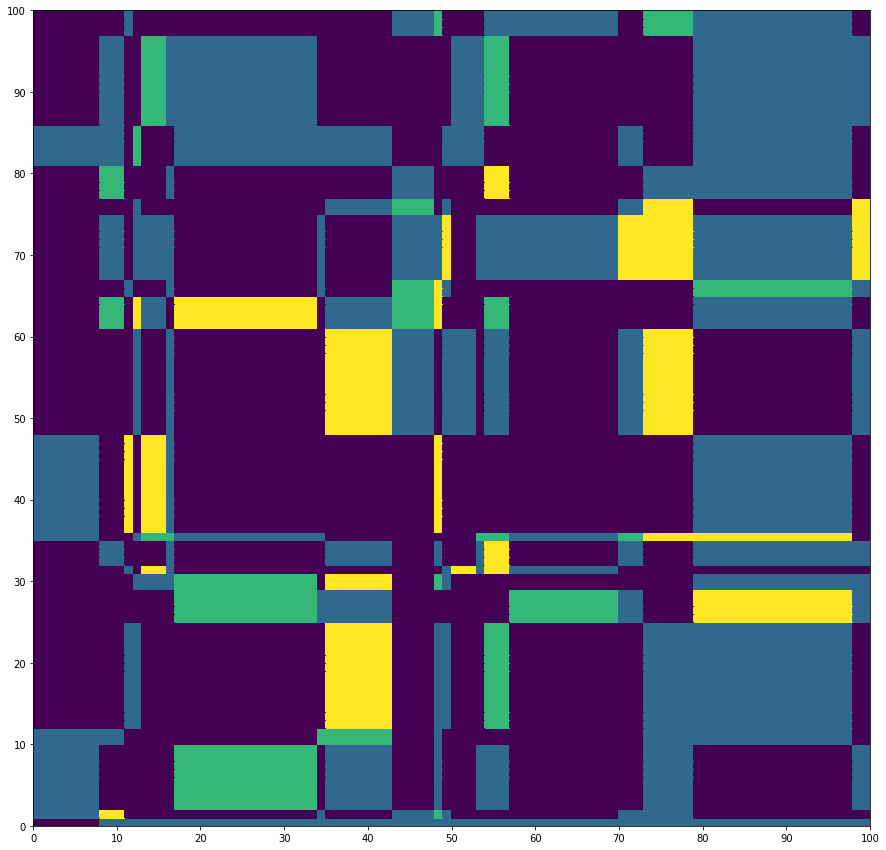

In [11]:
#t 将地图画出来
'''
0-其他区域-深深绿
1-住宅区-深绿
2-办公区-绿色
3-商贸区-黄色
'''
plt.figure(figsize=(15,15))
plt.pcolormesh(mmap,edgecolors='face')
#把x轴的刻度间隔设置为1，并存在变量里
x_major_locator=MultipleLocator(10)
#把y轴的刻度间隔设置为10，并存在变量里
y_major_locator=MultipleLocator(10)
#ax为两条坐标轴的实例
ax=plt.gca()
#把x轴的主刻度设置为50的倍数
ax.xaxis.set_major_locator(x_major_locator)
#把y轴的主刻度设置为50的倍数
ax.yaxis.set_major_locator(y_major_locator)
plt.show()

随机车辆，地图类型对需求产生的时间要求：
1. 住宅区：车辆需求点产生时间多半在中午和夜晚，时间17:00-21:00~7:00-9:00和11:00-12:00~13:30-14:00
2. 办公区：车辆需求点产生时间多半在上午和下午，时间7:00-9:00~11:00-12:00和13:30-14:00~17:00-21:00
3. 商贸区：时间8:00~21:00，时间段多数在2小时以上
4. 其他区域：时间不固定

随机的变量：充电需求产生的地址、充电需求产生的时间、预估的充电时长和车辆剩余行驶里程

随机车辆4000，其中2500遵循上班时间，1000遵循购物娱乐时间，500遵循在家时间

In [17]:
#1 随机时间
'''
car_cate
0-上班时间
时间：住宅区+办公区
地点：住宅+办公

1-娱乐时间
时间：住宅区+商贸区
地点：住宅+商贸

2-在家时间
时间：全天
地点：住宅
'''
#截断正态分布函数
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

car_num_0 = 2500
car_num_1 = 1000
car_num_2 = 500

# 上班时间
def cars_0():
    # 随机时间
    time_point_1_normal = get_truncated_normal(8.5, 1.5, 5, 10)
    time_point_1 = time_point_1_normal.rvs(car_num_0).reshape(car_num_0, 1)
    time_point_2_normal = get_truncated_normal(11.5, 0.5, 11, 12)
    time_point_2 = time_point_2_normal.rvs(car_num_0).reshape(car_num_0, 1)
    time_point_3_normal = get_truncated_normal(14, 0.5, 13, 15)
    time_point_3 = time_point_3_normal.rvs(car_num_0).reshape(car_num_0, 1)
    time_point_4_normal = get_truncated_normal(19, 1.5, 17, 21)
    time_point_4 = time_point_4_normal.rvs(car_num_0).reshape(car_num_0, 1)
    # 车辆id，为列向量
    car_id = np.arange(0,car_num_0).reshape(car_num_0, 1)
    # 随机地址
    addr_1_index = np.random.choice(a=np.argwhere(mmap==1).shape[0], size=car_num_0, replace=True)#住宅地址
    addr_1 = [np.argwhere(mmap==1)[i] for i in addr_1_index]
    addr_2_index = np.random.choice(a=np.argwhere(mmap==2).shape[0], size=car_num_0, replace=True)#办公地址
    addr_2 = [np.argwhere(mmap==2)[i] for i in addr_2_index]
    # 随机充电时长和剩余行驶里程(充电时长最长为3h, 行驶里程最长为500km)
    charge_time_normal = get_truncated_normal(1.5, 0.5, 0, 3)
    charge_time = charge_time_normal.rvs(car_num_0*4).reshape(car_num_0*4,1)
    remain_licheng = (3-charge_time)/3*500
    # 形成车辆需求
    
    car_id_con = np.concatenate((np.concatenate((car_id, car_id)), 
                                 np.concatenate((car_id, car_id))))
    time_point_con = np.concatenate((np.concatenate((time_point_1, time_point_2)), 
                                     np.concatenate((time_point_3, time_point_4))))
    addr_con = np.concatenate((np.concatenate((addr_2, addr_1)),
                               np.concatenate((addr_2, addr_1))))
    df_addr_con = pd.DataFrame(addr_con, columns = ['x','y'])
    #car_0_request = np.concatenate((np.concatenate((car_id_con, time_point_con), axis=1), 
    #                                np.concatenate((addr_con, charge_time), axis=1)), axis=1)
    #car_0_request = np.concatenate((car_0_request, remain_licheng), axis=1)
    # np.savetxt('data/car_0_request_test.txt', car_0_request, fmt='%f', delimiter=',')  
    df_car_0_request_read = pd.DataFrame(car_id_con, columns = ['车辆id'])
    df_car_0_request_read['充电需求产生的时间'] = time_point_con
    df_car_0_request_read['充电需求产生的地址'] = df_addr_con.apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_car_0_request_read['预估充电时长'] = charge_time
    df_car_0_request_read['车辆剩余行驶里程'] = remain_licheng
    df_car_0_request_read.to_csv(data_dir+'/df_car_0_request_read.csv')
    
    df_car_0_request = pd.DataFrame(car_id_con, columns = ['car_id'])
    df_car_0_request['time_point'] = time_point_con
    df_car_0_request['addr'] = df_addr_con.apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_car_0_request['charge_time'] = charge_time
    df_car_0_request['remain_licheng'] = remain_licheng
    df_car_0_request.to_csv(data_dir+'/df_car_0_request.csv')
    return df_car_0_request

# 娱乐时间
def cars_1():
    # 随机时间
    time_point_1_normal = get_truncated_normal(11, 1, 9, 13) # 去商场的时间点1
    time_point_1 = time_point_1_normal.rvs(int(car_num_1/2)).reshape(int(car_num_1/2), 1)
    time_point_2_normal = get_truncated_normal(15, 2, 13, 19) # 去商场的时间点2
    time_point_2 = time_point_2_normal.rvs(int(car_num_1/2)).reshape(int(car_num_1/2), 1)
    time_last_normal = get_truncated_normal(4, 1.5, 2, 11)
    time_last = time_last_normal.rvs(car_num_1).reshape(car_num_1, 1)
    time_point_temp = np.concatenate((np.concatenate((time_point_1, time_point_2)), time_last), axis=1)
    time_point_3 = np.zeros((car_num_1, 1))  #回住宅的时间
    tp_i = 0
    for tpt in time_point_temp: # 24小时制
        time_p = tpt[0]+tpt[1]
        if time_p > 24:
            time_p -= 24
        time_point_3[tp_i] = time_p
        tp_i += 1
    time_point_con = np.concatenate((np.concatenate((time_point_1, time_point_2)), time_point_3))
    # 车辆id，为列向量
    car_id = np.arange(car_num_0, car_num_0+car_num_1).reshape(car_num_1, 1)
    # 随机地址
    addr_1_index = np.random.choice(a=np.argwhere(mmap==1).shape[0], size=car_num_1, replace=False)#住宅地址
    addr_1 = [np.argwhere(mmap==1)[i] for i in addr_1_index]
    addr_3_index = np.random.choice(a=np.argwhere(mmap==3).shape[0], size=car_num_1, replace=True)#商贸地址
    addr_3 = [np.argwhere(mmap==3)[i] for i in addr_3_index]
    # 随机充电时长和剩余行驶里程(充电时长最长为3h, 行驶里程最长为500km)
    charge_time_normal = get_truncated_normal(1.5, 0.5, 0, 3)
    charge_time = charge_time_normal.rvs(car_num_1*2).reshape(car_num_1*2,1)
    remain_licheng = (3-charge_time)/3*500
    # 形成车辆需求
    car_id_con = np.concatenate((car_id, car_id))
    addr_con = np.concatenate((addr_3, addr_1))
    df_addr_con = pd.DataFrame(addr_con, columns = ['x','y'])
    #car_1_request = np.concatenate((np.concatenate((car_id_con, time_point_con), axis=1), 
    #                                np.concatenate((addr_con, charge_time), axis=1)), axis=1)
    #car_1_request = np.concatenate((car_1_request, remain_licheng), axis=1)
    # np.savetxt('data/car_1_request.txt', car_1_request, fmt='%f', delimiter=',')
    df_car_1_request_read = pd.DataFrame(car_id_con, columns = ['车辆id'])
    df_car_1_request_read['充电需求产生的时间'] = time_point_con
    df_car_1_request_read['充电需求产生的地址'] = df_addr_con.apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_car_1_request_read['预估充电时长'] = charge_time
    df_car_1_request_read['车辆剩余行驶里程'] = remain_licheng
    df_car_1_request_read.to_csv(data_dir+'/df_car_1_request_read.csv')
    
    df_car_1_request = pd.DataFrame(car_id_con, columns = ['car_id'])
    df_car_1_request['time_point'] = time_point_con
    df_car_1_request['addr'] = df_addr_con.apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_car_1_request['charge_time'] = charge_time
    df_car_1_request['remain_licheng'] = remain_licheng
    df_car_1_request.to_csv(data_dir+'/df_car_1_request.csv')
    return df_car_1_request


# 在家时间
def cars_2():
    # 随机时间
    time_point_normal = get_truncated_normal(12, 10, 0, 24)
    time_point = time_point_normal.rvs(car_num_2).reshape(car_num_2, 1)
    # 车辆id，为列向量
    car_id = np.arange(car_num_0+car_num_1,car_num_0+car_num_1+car_num_2).reshape(car_num_2, 1)
    # 随机地址
    addr_index = np.random.choice(a=np.argwhere(mmap==1).shape[0], size=car_num_2, replace=True)#住宅地址
    addr = [np.argwhere(mmap==1)[i] for i in addr_index]
    # 随机充电时长和剩余行驶里程(充电时长最长为3h, 行驶里程最长为500km)
    charge_time_normal = get_truncated_normal(1.5, 0.5, 0, 3)
    charge_time = charge_time_normal.rvs(car_num_2).reshape(car_num_2,1)
    remain_licheng = (3-charge_time)/3*500
    # 形成车辆需求
    df_addr_con = pd.DataFrame(addr, columns = ['x','y'])
    df_car_2_request_read = pd.DataFrame(car_id, columns = ['车辆id'])
    df_car_2_request_read['充电需求产生的时间'] = time_point
    df_car_2_request_read['充电需求产生的地址'] = df_addr_con.apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_car_2_request_read['预估充电时长'] = charge_time
    df_car_2_request_read['车辆剩余行驶里程'] = remain_licheng
    df_car_2_request_read.to_csv(data_dir+'/df_car_2_request_read.csv')
    
    df_car_2_request = pd.DataFrame(car_id, columns = ['car_id'])
    df_car_2_request['time_point'] = time_point
    df_car_2_request['addr'] = df_addr_con.apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_car_2_request['charge_time'] = charge_time
    df_car_2_request['remain_licheng'] = remain_licheng
    df_car_2_request.to_csv(data_dir+'/df_car_2_request.csv')
    return df_car_2_request

In [18]:
#1 写入文件
df_car_request = cars_0().append(cars_1()).append(cars_2())
df_car_request.to_csv(data_dir+'/df_car_request.csv')

In [4]:
# 读取充电需求数据
df_car_request = pd.read_csv(data_dir+'/df_car_request.csv', engine='python')
df_car_request.drop(df_car_request.columns[0], axis=1, inplace=True) # 删除第一列

## 预测城市充电需求，确定充电热区

该步骤是使用基于区域充电需求量的聚类算法实现的，具体步骤如下：
1. 数据清洗，由于会出现多个充电需求对应到同一需求点的情况，需要统计每个充电需求中预估的充电时长，之后计算每个需求点的总预估的充电时长作为该需求点的需求分数，公式如下：
$$SC_p=\sum_{i=1}^{n}ST_i$$
其中$SC_p$表示需求点$p$的需求分数，$ST_i$表示对应到需求点$p$的第$i$个充电需求中的预估充电时长
2. 删除需求分数过低的需求点，根据预先设置的阈值，删除需求分数低于阈值的需求点；
3. 使用K-means算法将需求点进行聚类，得到不同密度的簇，即充电热区，其代表着有一定充电需求的区域。

其中，步骤3中聚类个数K使用肘部法则来确定，将各个簇内的样本点到所在簇质心的距离平方和（SSE）作为性能度量，越小则说明各个类簇越收敛。但不是SSE越小越好，肘部法则就是在类簇数量与SSE之间寻求一个平衡点，具体步骤如下：

(1)指定一个i值，即可能的最大类簇数；

(2) 然后将类簇数从1开始递增，一直到$i$，计算出$i$个$SSE$，公式如下：
$$SSE=\sum_{k=1}^{k}\sum_{i\epsilon C_k}^{i}\lvert x_i-\mu k \rvert$$
其中，$\mu k$是第k个质心的位置

(3)通过画出K-SSE曲线，找出下降途中的拐点，即可较好的确定K值。

In [6]:
#1 1.数据清洗
def str_to_np(str_attr): #将字符串转换为numpy数组
    str_temp = str_attr[1:-1].strip().split(' ')
    if len(str_temp) > 2:
        str_temp[1] = str_temp[2]
        del str_temp[2]
    str_temp[0] = int(str_temp[0])
    str_temp[1] = int(str_temp[1])
    str_temp = np.asarray(str_temp)
    return str_temp

P_set = set(df_car_request['addr']) #需求点集合(dtype='object')
P_np = np.asarray([str_to_np(dfp) for dfp in P_set]) #需求点集合(dtype='np.array')
SCP_np = np.zeros(len(P_set)) # 需求点对应的需求分数
car_sum_np = np.zeros(len(P_set)) # 需求点对应的平均充电时间
it_scp = 0 #迭代数
for p in P_set: #计算需求分数
    it_df_p = df_car_request[df_car_request['addr'] == p]
    scp = it_df_p['charge_time'].sum()
    SCP_np[it_scp] = scp
    car_sum_np[it_scp] = len(it_df_p['charge_time'])
    it_scp += 1
    
df_p_np = pd.DataFrame(P_np, columns = ['x','y'])

df_scp = pd.DataFrame(df_p_np.apply(lambda r: tuple(r), axis=1).apply(np.array), columns=['addr'])
SCP_np.reshape(len(P_set), 1)
df_scp['scp'] = SCP_np
df_scp['car_sum'] = car_sum_np

# 2.删除需求分数过低的需求点（小于1的）
del_labels = np.where(SCP_np < 3)
del_labels = del_labels[0]
df_scp = df_scp.drop(del_labels)
# 将需求存入文件
df_scp.to_csv(data_dir+'/df_scp.csv') 

In [21]:
#t
print('需求分数小于1.5的占比：'+str(sum(SCP_np < 1.5)*100/len(SCP_np))+'%')
print('需求分数小于2.5的占比：'+str(sum(SCP_np < 2.5)*100/len(SCP_np))+'%')
print('需求分数小于3的占比：'+str(sum(SCP_np < 3)*100/len(SCP_np))+'%')
print('需求分数小于4的占比：'+str(sum(SCP_np < 4)*100/len(SCP_np))+'%')
print('需求分数小于5的占比：'+str(sum(SCP_np < 5)*100/len(SCP_np))+'%')

需求分数小于1.5的占比：11.912316123449669%
需求分数小于2.5的占比：28.872223824632247%
需求分数小于3的占比：37.00605710989328%
需求分数小于4的占比：52.61032593019902%
需求分数小于5的占比：62.070954715892704%


In [8]:
# 读取df_scp

def str_to_np(df_scp_0): #将df_scp中地址转换为numpy数组
    scp_0_array = np.zeros((len(df_scp_0), 2))
    it = 0
    for df_0 in df_scp_0:
        str_temp = df_0[1:-1].strip().split(' ')
        if len(str_temp) > 2:
            str_temp[1] = str_temp[2]
            del str_temp[2]
        str_temp[0] = int(str_temp[0])
        str_temp[1] = int(str_temp[1])
        scp_0_array[it] = [str_temp[0], str_temp[1]]
        it += 1
    return scp_0_array

df_scp = pd.read_csv(data_dir+'/df_scp.csv', engine='python')
df_scp.drop(df_scp.columns[0], axis=1, inplace=True) # 删除第一列


np_df_scp_addr = str_to_np(df_scp['addr']) # 需求点地址numpy数组
#np_df_scp_addr = df_scp['addr']
np_df_scp_scp = np.asarray(df_scp['scp']) # 需求点分数的numpy数组
np_df_scp_car_sum = np.asarray(df_scp['car_sum']) # 需求点车辆总数

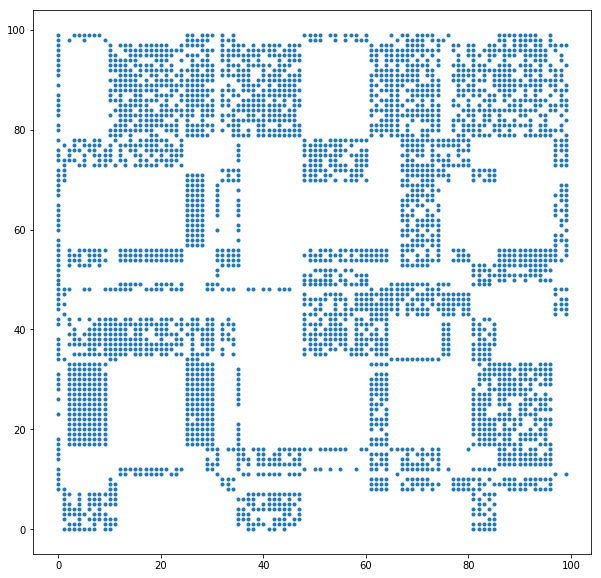

In [9]:
#t 需求点分布
plt.figure(figsize=(10,10))
plt.plot([x[0] for x in np_df_scp_addr], [x[1] for x in np_df_scp_addr], '.')
plt.show()

In [24]:
# 聚类定义
# np_df_scp_addr np_df_scp_scp

# 计算每个点到聚类中心的距离，并存入np_df_scp_centroids，即每个需求点对应的聚类中心
def assign(addr_attr, centroids):
    centroids_attr = np.zeros((len(addr_attr), 2))
    it_ndsc = 0
    for addr in addr_attr:
        distence = np.sqrt(np.sum(np.square(addr-centroids), axis=1))
        centroids_attr[it_ndsc] = centroids[np.argmin(distence)]
        it_ndsc += 1
    return centroids_attr


# 计算某聚类中心和所有需求点的距离之和
def cal_dis(addr_attr, centroid_attr):
    distence_1 = np.sum(np.sqrt(np.sum(np.square(addr_attr-centroid_attr), axis=1)))
    return distence_1
                            
# 聚类
def clustering(num_cluster):
    #随机从需求点中选取num_cluster个初始聚类中心
    cluster_centroids_index = np.random.choice(a=np.arange(len(np_df_scp_addr)), size=num_cluster, replace=False)
    cluster_centroids = np.asarray([np_df_scp_addr[i] for i in cluster_centroids_index])
    #print(cluster_centroids)
    cluster_rounds = 0 # 聚类次数
    sse = 0 # 不平衡度
    while cluster_rounds < 50:
        sse = 0
        np_df_scp_centroids = assign(np_df_scp_addr, cluster_centroids) # 计算每个点的聚类中心
        # 更新聚类中心
        new_cluster_centroids = np.zeros((num_cluster, 2))
        it_ncc = 0
        for centroid in cluster_centroids:
            # 取出属于同一聚类中心的点的索引
            index = []
            for i in range(len(np_df_scp_centroids)):
                if np_df_scp_centroids[i][0] == centroid[0] and np_df_scp_centroids[i][1] == centroid[1]:
                    index.append(i)
            addr_temp = np.zeros((len(index), 2))# 簇集合
            it_at = 0
            for i in index:
                addr_temp[it_at] = np_df_scp_addr[i]
                it_at += 1
            addr_temp = np.asarray(addr_temp)
            sse += cal_dis(addr_temp, centroid)# 计算不平衡度
            new_cluster_centroids[it_ncc] = np.mean(addr_temp, axis=0)
            it_ncc += 1
        cluster_centroids = np.asarray(new_cluster_centroids)
        cluster_rounds += 1
    np.savetxt(data_dir+'/cluster_cen/cluster_centroids_'+str(num_cluster)+'.txt', cluster_centroids)
    return sse

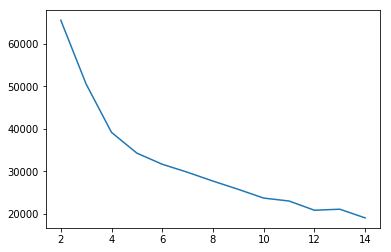

In [25]:
def sse():
    sse = []
    for k in range(2, 15):
        sse.append(clustering(k))
    return sse

x = np.arange(2, 15)

plt.plot(x, sse())
plt.show()

## 调整充电热区，确定充电站候选区域

总体方法为融合较小的簇、分割较大的簇，具体步骤如下：
1. 计算充电热区的半径和充电热区之间的距离矩阵；
2. 若某一充电热区和其他充电热区的距离小于r，则以半径r合并充电热区，其中r与电动汽车充满电的续航里程相关，r是为了保证电动汽车的剩余电量可以支撑其行驶到充电站，根据历史数据中电动汽车在该区域的平均剩余电量，可以利用现有方法估算行驶里程l，则$r=l$
3. 若充电热区的半径大于阈值r则在该热区内再次运行K-means算法划分新的充电热区，重复步骤1；
4. 得到充电站候选区域集合。

In [26]:
# 取出聚类中心
f_cluster_centroids = np.loadtxt(data_dir+'/cluster_cen/cluster_centroids_5.txt')
f_cluster_centroids

array([[69.35543767, 48.67904509],
       [17.19699812, 25.87242026],
       [81.46428571, 17.54545455],
       [77.77958237, 85.05336427],
       [26.06168224, 80.26728972]])

In [27]:
# 计算充电热区半径

# 计算距离 (多对一)
def cal_dis_2(addr_attr, centroid_attr):
    distence = np.sqrt(np.sum(np.square(addr_attr-centroid_attr), axis=1))
    return distence

# 计算充电热区之间的距离矩阵
def cal_dis_cen(centroids):
    dis = []
    for cen in centroids:
        distence = cal_dis_2(centroids, cen)
        distence.reshape(1, len(centroids))
        dis.append(distence)
    dis = np.asarray(dis)
    return dis

# 获得index (多对一)
# attr_1 : (,2)
# attr_2 : (1,2)
def equal_index(attr_1, attr_2):
    index = []
    for i in range(len(attr_1)):
        if attr_1[i][0] == attr_2[0] and attr_1[i][1] == attr_2[1]:
            index.append(i)
    return index

# 获得同一簇心的候选点
def get_addr(all_addr, centroids, centroid):
    np_df_scp_centroids_temp = assign(all_addr, centroids) # 将所有地址归类
    index = equal_index(np_df_scp_centroids_temp, centroid) # 取出属于centroid的需求点索引
    addr = np.zeros((len(index), 2))# 簇集合
    it_at = 0
    for i in index:
        addr[it_at] = all_addr[i]
        it_at += 1
    addr = np.asarray(addr)
    return addr

# 计算热区实际半径
def cal_real_r(addr_attr, centroids):
    real_radius = [] # 实际半径
    np_df_scp_centroids_temp = assign(addr_attr, centroids)# 将每个需求点归类
    for cen in centroids:
        addr = np.asarray([addr_attr[i] for i in equal_index(np_df_scp_centroids_temp, cen)])
        distence = np.sqrt(np.sum(np.square(addr-cen), axis=1))
        real_radius.append(np.amax(distence))
    real_radius = np.asarray(real_radius)
    return real_radius

# 计算热区应有半径
def cal_ideal_r(addr, centroids):
    ideal_r = []
    np_df_scp_centroids_temp = assign(addr, centroids)# 将每个需求点归类
    for centroid in centroids:
        index = equal_index(np_df_scp_centroids_temp, centroid) # 找出簇内候选点
        cars_num = sum([np_df_scp_car_sum[i] for i in index])
        scp = sum([np_df_scp_scp[i] for i in index])
        ideal_r.append(scp/cars_num*10)
    ideal_r = np.asarray(ideal_r)
    return ideal_r

# 聚类
def clustering_2(addr):
    num_cluster=2
    #随机从需求点中选取num_cluster个初始聚类中心
    cluster_centroids_index = np.random.choice(a=np.arange(len(addr)), size=num_cluster, replace=False)
    cluster_centroids = np.asarray([addr[i] for i in cluster_centroids_index])
    # print(cluster_centroids)
    cluster_rounds = 0 # 聚类次数
    sse = 0 # 不平衡度
    while cluster_rounds < 20:
        sse = 0
        # 更新聚类中心
        new_cluster_centroids = np.zeros((num_cluster, 2))
        it_ncc = 0
        for centroid in cluster_centroids:
            addr_temp = get_addr(addr, cluster_centroids, centroid)
            sse += cal_dis(addr_temp, centroid)# 计算不平衡度
            new_cluster_centroids[it_ncc] = np.mean(addr_temp, axis=0)
            it_ncc += 1
        cluster_centroids = np.asarray(new_cluster_centroids)
        cluster_rounds += 1
    #np.savetxt('data/cluster_cen_2/cluster_centroids_'+str(cluster)+'.txt', cluster_centroids)
    return cluster_centroids

In [28]:
#1 调整充电热区
# 判断是否达到条件
def is_qualified(ideal_r, real_r):
    '''
    for i in range(len(ideal_r)):
        if ideal_r[i] < real_r[i]:
            return True
    '''    
    return True

def ajust_cluster(addr_attr, centroids):
    dis_cen = cal_dis_cen(centroids)
    ideal_r = cal_ideal_r(addr_attr, centroids)
    real_r = cal_real_r(addr_attr, centroids)
    while True:
        new_centroids = np.zeros((len(centroids)*2, 2))
        for i in range(len(centroids)):
            i_r = ideal_r[i]
            r_r = real_r[i]
            d_c = dis_cen[i]
            if i_r < r_r:
                addr = get_addr(addr_attr, centroids, centroids[i])
                clu_temp = clustering_2(addr)
                new_centroids[i*2] = clu_temp[0]
                new_centroids[i*2+1] = clu_temp[1]
        centroids = np.asarray(new_centroids)
        print(centroids)
        dis_cen = cal_dis_cen(centroids)
        ideal_r = cal_ideal_r(addr_attr, centroids)
        real_r = cal_real_r(addr_attr, centroids)
        if is_qualified(ideal_r, real_r):
            np.savetxt(data_dir+'/cluster_centroids_temp.txt', centroids)
            return centroids
    



ajust_cluster(np_df_scp_addr, f_cluster_centroids)

[[83.81045752 49.79738562]
 [59.48214286 47.91517857]
 [11.19169329 34.19169329]
 [25.74090909 14.03636364]
 [69.71666667 11.54166667]
 [88.96276596 21.37765957]
 [89.14285714 85.74761905]
 [66.98190045 84.39366516]
 [29.9702381  88.10416667]
 [19.46231156 67.03517588]]


array([[83.81045752, 49.79738562],
       [59.48214286, 47.91517857],
       [11.19169329, 34.19169329],
       [25.74090909, 14.03636364],
       [69.71666667, 11.54166667],
       [88.96276596, 21.37765957],
       [89.14285714, 85.74761905],
       [66.98190045, 84.39366516],
       [29.9702381 , 88.10416667],
       [19.46231156, 67.03517588]])

## 确定充电站内的充电桩数量

1. 统计候选区域内候选点的停留时长及其时间段（每小时为1个时间段）；
2. 将停留时长除以3作为该候选点在其停留时间段的充电需求值； 
3. 统计候选区域内所有时间段的充电需求和，将其除以10作为候选区域的充电桩数量。

In [29]:
# 读取聚类中心
cluster_centroids_final = np.loadtxt(data_dir+'/cluster_centroids_temp.txt')

In [30]:
#1 确定充电桩数量

def charging_pile_num(addr_attr, centroids, scp_attr):
    pile_num = []
    np_df_scp_centroids_temp = assign(addr_attr, centroids) # 将每个需求点归类
    for cen in centroids:
        index = equal_index(np_df_scp_centroids_temp, cen) # 取出索引
        # print(len(index))
        pile_num.append(sum([scp_attr[i] for i in index])/30)
    pile_num = np.asarray(pile_num)
    return pile_num

charging_p_n = charging_pile_num(np_df_scp_addr, cluster_centroids_final, np_df_scp_scp)
charging_p_n = np.ceil(charging_p_n)
np.savetxt(data_dir+'/charging_pile_num.txt', charging_p_n)

## 利用遗传算法实现最优布局

1. 创建初始种群，在遗传算法中，使用固定长度的二进制串来表示群体中的个体，将n个候选点编号为1-n，并根据是否设置充电站，将染色体上的基因进行编码，由{0，1}组成，0表示不设置充电站，1表示设置充电站；
2. 设置种群的个体适应度函数，个体适应度函数是布局目标的数学表达，考虑两个因素——用户和管理者因素，具体为用户的时间费用（平均行驶时间、充电排队时间）、管理者的建站费用（充电站的个数），公式如下：
$$S=\sum_{i\epsilon C}(\frac{\lambda_1}{num_j}\sum_{j\epsilon C_i}(t_{j1}+t_{j2})+\lambda_2\frac{1}{num_i})$$
其中，$C$表示充电站集合，表示第$i$个充电站，$j$表示选择作为充电目标的电动汽车，$t_{j1}$表示行驶时间，$t_{j2}$表示排队时间，$num_j$和$num_i$分别表示充电站的个数和选择此充电站的电动汽车个数，$\lambda_1$和$\lambda_2$代表用户时间费用和管理者建站费用的系数，通过实验得出，因此，布局目标是用户到达最近充电站的耗时和成电站个数最少。
3. 执行遗传算子不断迭代得到最终解；

In [31]:
# 随机数据
# 上面已经读取聚类中心cluster_centroids_final

np_df_scp_centroids = assign(np_df_scp_addr, cluster_centroids_final) # 将每个需求点归类

# 计算车辆数目
def car_num(i, centroids_attr):
    cen = centroids_attr[i]
    index = equal_index(np_df_scp_centroids, cen) # 取出索引
    car_num_attr = sum([np_df_scp_car_sum[j] for j in index])
    return car_num_attr

In [32]:
tj1 = np.random.randint(1, 200, 10)
tj2 = np.random.randint(1, 100, 10)
lamda_1 = np.random.randint(1, 100, 10)
lamda_2 = np.random.randint(1, 100, 10)

In [33]:
# 遗传算法
class GA:
    # 遗传算法的参数
    sol_per_pop = None # 种群染色体数目
    num_parents_mating = None # 在交配池中选择作为父代的染色体数
    num_generations = None # 遗传代数
    pop_size = None # 种群大小 = (染色体个数, 每个染色体的基因个数)
    # If 0, 当前父种群不会进入下一代
    # If -1, 当前父种群都会进入下一代
    # If set to a value > 0, then the specified value refers to the number of parents in the current population to be used in the next population. In some cases, the parents are of high quality and thus we do not want to loose such some high quality solutions. If some parent selection operators like roulette wheel selection (RWS), the parents may not be of high quality and thus keeping the parents might degarde the quality of the population.
    keep_parents = -1
    fitness_func = None

    # 关于父种群选择的参数
    parent_selection_type = None # 父代的选择类型
    select_parents = None # Refers to a method that selects the parents based on the parent selection type specified in parent_selection_type.
    
    K_tournament = None # For tournament selection, a parent is selected out of K randomly selected solutions.

    population = None # 种群 np array 
    
    crossover_type = None # 交叉算子的类型
    crossover = None # A method that applies the crossover operator based on the selected type of crossover in the crossover_type property.

    mutation_type = None # 变异算子的类型
    mutation = None # A method that applies the mutation operator based on the selected type of mutation in the mutation_type property.

    best_solution_fitness = [] # A list holding the fitness value of the best solution for each generation.

    # 要优化的函数的参数
    function_inputs = None # 要优化的函数的输入
    function_output = None # 函数的期望输出
    num_genes = None

    # 变异参数
    mutation_percent_genes=None # 变异的(基因)百分比，如果参数 mutation_num_genes 存在那这个参数就不起作用
    mutation_num_genes=None # 变异的基因个数. 如果参数 mutation_num_genes 存在, 那就不需要 mutation_percent_genes.
    random_mutation_min_val=None
    random_mutation_max_val=None

    # Some flags.
    run_completed = False # 只有 run() 函数漂亮地完成才能设置为 True.
    valid_parameters = False # 当输入GA类构造器的所有参数都被验证后才设置为 True.

    def __init__(self, num_generations, 
                 sol_per_pop, 
                 num_parents_mating, 
                 num_genes, 
                 fitness_func,
                 parent_selection_type="sss",
                 keep_parents=-1,
                 K_tournament=3,
                 crossover_type="single_point",
                 mutation_type="random",
                 mutation_percent_genes=10,
                 mutation_num_genes=None,
                 random_mutation_min_val=-1.0,
                 random_mutation_max_val=1.0):

        # 验证种群染色体数目 (sol_per_pop) 和 在交配池中选择作为父代的染色体数 (num_parents_mating)
        if (sol_per_pop <= 0 or num_parents_mating <= 0):
            print("ERROR 创建的 GA 实例里有非法参数. \n下面的参数必须 > 0: \n1) 个体大小 (i.e. 个体的染色体数目) (sol_per_pop).\n2) 在交配池中选择作为父代的染色体数 (num_parents_mating).\n")
            self.valid_parameters = False
            return

        # 验证基因个数        
        if (num_genes <= 0):
            print("ERROR: 基因个数不能 <= 0. \n")
            self.valid_parameters = False
            return

        self.num_genes = num_genes # 染色体中基因个数

        if (mutation_num_genes == None):
            if (mutation_percent_genes < 0 or mutation_percent_genes > 100):
                print("ERROR: 变异的基因的百分比 (mutation_percent_genes) 必须 >= 0 <= 100.\n")
                self.valid_parameters = False
                return
        elif (mutation_num_genes <= 0 ):
            print("ERROR: 变异的基因个数 (mutation_num_genes) 不能 <= 0.\n")
            self.valid_parameters = False
            return
        elif (mutation_num_genes > self.num_genes):
            print("ERROR: 变异的基因个数 (mutation_num_genes) 不能大于函数中的参数个数.\n")
            self.valid_parameters = False
            return
        elif (type(mutation_num_genes) is not int):
            print("Warning: 变异的基因个数 (mutation_num_genes) 必须是个正整数 >= 1.\n")
            self.valid_parameters = False
            return

        # 验证在交配池中选择作为父代的染色体数: num_parents_mating
        if (num_parents_mating > sol_per_pop):
            print("ERROR creating an instance of the GA class with invalid parameters. \nThe number of parents to select for mating cannot be greater than the number of solutions in the population (i.e., num_parents_mating must always be <= sol_per_pop).\n")
            self.valid_parameters = False
            return

        # 验证交叉类型: crossover_type
        if (crossover_type == "single_point"):
            self.crossover = self.single_point_crossover
        elif (crossover_type == "two_points"):
            self.crossover = self.two_points_crossover
        elif (crossover_type == "uniform"):
            self.crossover = self.uniform_crossover
        else:
            print("ERROR: 未定义的交叉类型 \nThe assigned value to the crossover_type argument does not refer to one of the supported crossover types which are: \n-single_point (for single point crossover)\n-two_points (for two points crossover)\n-uniform (for uniform crossover).\n")
            self.valid_parameters = False
            return

        self.crossover_type = crossover_type

        # 验证变异类型: mutation_type
        if (mutation_type == "random"):
            self.mutation = self.random_mutation
        elif (mutation_type == "swap"):
            self.mutation = self.swap_mutation
        elif (mutation_type == "scramble"):
            self.mutation = self.scramble_mutation
        elif (mutation_type == "inversion"):
            self.mutation = self.inversion_mutation
        else:
            print("ERROR: 未定义的变异类型. \nThe assigned value to the mutation_type argument does not refer to one of the supported mutation types which are: \n-random (for random mutation)\n-swap (for swap mutation)\n-inversion (for inversion mutation)\n-scramble (for scramble mutation).\n")
            self.valid_parameters = False
            return

        self.mutation_type = mutation_type

        # 验证父代选择类型: parent_selection_type
        if (parent_selection_type == "sss"):
            self.select_parents = self.steady_state_selection
        elif (parent_selection_type == "rws"):
            self.select_parents = self.roulette_wheel_selection
        elif (parent_selection_type == "sus"):
            self.select_parents = self.stochastic_universal_selection
        elif (parent_selection_type == "random"):
            self.select_parents = self.random_selection
        elif (parent_selection_type == "tournament"):
            self.select_parents = self.tournament_selection
        elif (parent_selection_type == "rank"):
            self.select_parents = self.rank_selection
        else:
            print("ERROR: 未定义的父代选择类型. \nThe assigned value to the parent_selection_type argument does not refer to one of the supported parent selection techniques which are: \n-sss (for steady state selection)\n-rws (for roulette wheel selection)\n-sus (for stochastic universal selection)\n-rank (for rank selection)\n-random (for random selection)\n-tournament (for tournament selection).\n")
            self.valid_parameters = False
            return

        if(parent_selection_type == "tournament"):
            if (K_tournament > sol_per_pop):
                K_tournament = sol_per_pop
                print("Warining: K of the tournament selection should not be greater than the number of solutions within the population.\nK will be clipped to be equal to the number of solutions in the population (sol_per_pop).\n")
            elif (K_tournament <= 0):
                print("ERROR: K of the tournament selection cannot be <=0.\n")
                self.valid_parameters = False
                return

        self.K_tournament = K_tournament

        # 验证进入下一代种群的父代染色体数目: keep_parents
        if (keep_parents > sol_per_pop or keep_parents > num_parents_mating or keep_parents < -1):
            print("ERROR: 不正确的值赋予 keep_parents 参数. \nThe assigned value to the keep_parent parameter must satisfy the following conditions: \n1) Less than or equal to sol_per_pop\n2) Less than or equal to num_parents_mating\n3) Greater than or equal to -1.\n")
            self.valid_parameters = False
            return

        self.keep_parents = keep_parents

        if (self.keep_parents == -1): # Keep all parents in the next population.
            self.num_offspring = sol_per_pop - num_parents_mating
        elif (self.keep_parents == 0): # Keep no parents in the next population.
            self.num_offspring = sol_per_pop
        elif (self.keep_parents > 0): # Keep the specified number of parents in the next population.
            self.num_offspring = sol_per_pop - self.keep_parents

        # At this point, all necessary parameters validation is done successfully and we are sure that the parameters are valid.
        self.valid_parameters = True

        self.fitness_func = fitness_func

        # 遗传算法的参数
        self.sol_per_pop = sol_per_pop
        self.num_parents_mating = num_parents_mating
        self.num_generations = abs(num_generations)
        self.parent_selection_type = parent_selection_type
        
        # 变异算子的参数
        self.mutation_percent_genes = mutation_percent_genes
        self.mutation_num_genes = mutation_num_genes
        self.random_mutation_min_val = random_mutation_min_val
        self.random_mutation_max_val = random_mutation_max_val

        # Even such this parameter is declared in the class header, it is assigned to the object here to access it after saving the object.
        self.best_solution_fitness = []

        # 创建初始种群
        self.initialize_population()

    def initialize_population(self):
        """
        创建初始种群
        """
        self.pop_size = (self.sol_per_pop,self.num_genes) # The population will have sol_per_pop chromosome where each chromosome has num_genes genes.
        # 随机创建初始种群
        self.population = np.random.randint(low=0, high=2, size=self.pop_size)

    def run(self):
        """
        运行遗传算法. This is the main method in which the genetic algorithm is evolved through a number of generations.
        """
        if self.valid_parameters == False:
            print("ERROR calling the run() method: \n run() method 不能有非法参数. 请在创建GA实例的时候检查输入的参数合法性\n")
            return

        for generation in range(self.num_generations):
            # 衡量种群每个染色体的适应度
            fitness = self.cal_pop_fitness()

            # 选择最优的交配父代
            parents = self.select_parents(fitness, num_parents=self.num_parents_mating)

            # 交叉形成下一代
            offspring_crossover = self.crossover(parents,
                                                 offspring_size=(self.num_offspring, self.num_genes))

            # 变异
            offspring_mutation = self.mutation(offspring_crossover)

            if (self.keep_parents == 0):
                self.population = offspring_mutation
            elif (self.keep_parents == -1):
                # 基于父代和后代形成新的种群
                self.population[0:parents.shape[0], :] = parents
                self.population[parents.shape[0]:, :] = offspring_mutation
            elif (self.keep_parents > 0):
                parents_to_keep = self.steady_state_selection(fitness, num_parents=self.keep_parents)
                self.population[0:parents_to_keep.shape[0], :] = parents_to_keep
                self.population[parents_to_keep.shape[0]:, :] = offspring_mutation

        # 当run() 运行完成后, run_completed flag 从 False 变为 True.
        self.run_completed = True

    def cal_pop_fitness(self):
        """
        计算当前种群所有染色体的适应度
        It returns:
            -fitness: An array of the calculated fitness values.
        """
        if self.valid_parameters == False:
            print("ERROR calling the cal_pop_fitness() method: \nPlease check the parameters passed while creating an instance of the GA class.\n")
            return []

        pop_fitness = []
        # 计算当前种群的每个染色体的适应度
        for sol in self.population:
            print(sol)
            fitness = self.fitness_func(sol)
            pop_fitness.append(fitness)
        
        pop_fitness = np.array(pop_fitness)

        # The best result in the current iteration.
        self.best_solution_fitness.append(np.max(pop_fitness))

        return pop_fitness

    def steady_state_selection(self, fitness, num_parents):
        fitness_sorted = sorted(range(len(fitness)), key=lambda k: fitness[k])
        fitness_sorted.reverse()
        # 选择当前最优的个体作为下一代的父代
        parents = np.empty((num_parents, self.population.shape[1]))
        for parent_num in range(num_parents):
            parents[parent_num, :] = self.population[fitness_sorted[parent_num], :]
        return parents

    def rank_selection(self, fitness, num_parents):
        fitness_sorted = sorted(range(len(fitness)), key=lambda k: fitness[k])
        fitness_sorted.reverse()
        # 选择当前最优的个体作为下一代的父代
        parents = np.empty((num_parents, self.population.shape[1]))
        for parent_num in range(num_parents):
            parents[parent_num, :] = self.population[fitness_sorted[parent_num], :]
        return parents

    def random_selection(self, fitness, num_parents):
        parents = np.empty((num_parents, self.population.shape[1]))

        rand_indices = np.random.randint(low=0.0, high=fitness.shape[0], size=num_parents)

        for parent_num in range(num_parents):
            parents[parent_num, :] = self.population[rand_indices[parent_num], :]
        return parents

    def tournament_selection(self, fitness, num_parents):
        parents = np.empty((num_parents, self.population.shape[1]))
        for parent_num in range(num_parents):
            rand_indices = np.random.randint(low=0.0, high=len(fitness), size=self.K_tournament)
            K_fitnesses = fitness[rand_indices]
            selected_parent_idx = np.where(K_fitnesses == np.max(K_fitnesses))[0][0]
            parents[parent_num, :] = self.population[rand_indices[selected_parent_idx], :]
        return parents

    def roulette_wheel_selection(self, fitness, num_parents):
        fitness_sum = np.sum(fitness)
        probs = fitness / fitness_sum
        probs_start = np.zeros(probs.shape, dtype=np.float) # An array holding the start values of the ranges of probabilities.
        probs_end = np.zeros(probs.shape, dtype=np.float) # An array holding the end values of the ranges of probabilities.

        curr = 0.0

        # Calculating the probabilities of the solutions to form a roulette wheel.
        for _ in range(probs.shape[0]):
            min_probs_idx = np.where(probs == np.min(probs))[0][0]
            probs_start[min_probs_idx] = curr
            curr = curr + probs[min_probs_idx]
            probs_end[min_probs_idx] = curr
            probs[min_probs_idx] = 99999999999

        # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
        parents = np.empty((num_parents, self.population.shape[1]))
        for parent_num in range(num_parents):
            rand_prob = np.random.rand()
            for idx in range(probs.shape[0]):
                if (rand_prob >= probs_start[idx] and rand_prob < probs_end[idx]):
                    parents[parent_num, :] = self.population[idx, :]
                    break
        return parents

    def stochastic_universal_selection(self, fitness, num_parents):
        fitness_sum = np.sum(fitness)
        probs = fitness / fitness_sum
        probs_start = np.zeros(probs.shape, dtype=np.float) # An array holding the start values of the ranges of probabilities.
        probs_end = np.zeros(probs.shape, dtype=np.float) # An array holding the end values of the ranges of probabilities.

        curr = 0.0

        # Calculating the probabilities of the solutions to form a roulette wheel.
        for _ in range(probs.shape[0]):
            min_probs_idx = np.where(probs == np.min(probs))[0][0]
            probs_start[min_probs_idx] = curr
            curr = curr + probs[min_probs_idx]
            probs_end[min_probs_idx] = curr
            probs[min_probs_idx] = 99999999999

        pointers_distance = 1.0 / self.num_parents_mating # Distance between different pointers.
        first_pointer = np.random.uniform(low=0.0, high=pointers_distance, size=1) # Location of the first pointer.

        # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
        parents = np.empty((num_parents, self.population.shape[1]))
        for parent_num in range(num_parents):
            rand_pointer = first_pointer + parent_num*pointers_distance
            for idx in range(probs.shape[0]):
                if (rand_pointer >= probs_start[idx] and rand_pointer < probs_end[idx]):
                    parents[parent_num, :] = self.population[idx, :]
                    break
        return parents

    def single_point_crossover(self, parents, offspring_size):
        offspring = np.empty(offspring_size)
        # The point at which crossover takes place between two parents. Usually, it is at the center.
        crossover_point = np.random.randint(low=0, high=parents.shape[1], size=1)[0]

        for k in range(offspring_size[0]):
            # 第一个用于交叉的父代的索引
            parent1_idx = k % parents.shape[0]
            # 第二个用于交叉的父代的索引
            parent2_idx = (k+1) % parents.shape[0]
            # The new offspring will have its first half of its genes taken from the first parent.
            offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
            # The new offspring will have its second half of its genes taken from the second parent.
            offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
        return offspring

    def two_points_crossover(self, parents, offspring_size):
        offspring = np.empty(offspring_size)
        if (parents.shape[1] == 1): # If the chromosome has only a single gene. In this case, this gene is copied from the second parent.
            crossover_point1 = 0
        else:
            crossover_point1 = np.random.randint(low=0, high=np.ceil(parents.shape[1]/2 + 1), size=1)[0]

        crossover_point2 = crossover_point1 + int(parents.shape[1]/2) # The second point must always be greater than the first point.

        for k in range(offspring_size[0]):
            # 第一个用于交叉的父代的索引
            parent1_idx = k % parents.shape[0]
            # 第二个用于交叉的父代的索引
            parent2_idx = (k+1) % parents.shape[0]
            # The genes from the beginning of the chromosome up to the first point are copied from the first parent.
            offspring[k, 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
            # The genes from the second point up to the end of the chromosome are copied from the first parent.
            offspring[k, crossover_point2:] = parents[parent1_idx, crossover_point2:]
            # The genes between the 2 points are copied from the second parent.
            offspring[k, crossover_point1:crossover_point2] = parents[parent2_idx, crossover_point1:crossover_point2]
        return offspring

    def uniform_crossover(self, parents, offspring_size):
        offspring = np.empty(offspring_size)

        for k in range(offspring_size[0]):
            # 第一个用于交叉的父代的索引
            parent1_idx = k % parents.shape[0]
            # 第二个用于交叉的父代的索引
            parent2_idx = (k+1) % parents.shape[0]

            genes_source = np.random.randint(low=0, high=2, size=offspring_size[1])
            for gene_idx in range(offspring_size[1]):
                if (genes_source[gene_idx] == 0):
                    # The gene will be copied from the first parent if the current gene index is 0.
                    offspring[k, gene_idx] = parents[parent1_idx, gene_idx]
                elif (genes_source[gene_idx] == 1):
                    # The gene will be copied from the second parent if the current gene index is 1.
                    offspring[k, gene_idx] = parents[parent2_idx, gene_idx]
        return offspring

    def random_mutation(self, offspring):
        if self.mutation_num_genes == None:
            self.mutation_num_genes = np.uint32((self.mutation_percent_genes*offspring.shape[1])/100)
            # Based on the percentage of genes, if the number of selected genes for mutation is less than the least possible value which is 1, then the number will be set to 1.
            if self.mutation_num_genes == 0:
                self.mutation_num_genes = 1
        mutation_indices = np.array(random.sample(range(0, offspring.shape[1]), self.mutation_num_genes))
        # Random mutation changes a single gene in each offspring randomly.
        for idx in range(offspring.shape[0]):
            # The random value to be added to the gene.
            random_value = np.random.uniform(self.random_mutation_min_val, self.random_mutation_max_val, 1)
            offspring[idx, mutation_indices] = offspring[idx, mutation_indices] + random_value
        return offspring

    def swap_mutation(self, offspring):
        """
        选择互换两个随机选择的基因的值
        It accepts a single parameter:
            -offspring: The offspring to mutate.
        It returns:
            -offspring: The offspring after mutation.
        """
        for idx in range(offspring.shape[0]):
            mutation_gene1 = np.random.randint(low=0, high=offspring.shape[1]/2, size=1)[0]
            mutation_gene2 = mutation_gene1 + int(offspring.shape[1]/2)

            temp = offspring[idx, mutation_gene1]
            offspring[idx, mutation_gene1] = offspring[idx, mutation_gene2]
            offspring[idx, mutation_gene2] = temp
        return offspring

    def inversion_mutation(self, offspring):
        for idx in range(offspring.shape[0]):
            mutation_gene1 = np.random.randint(low=0, high=np.ceil(offspring.shape[1]/2 + 1), size=1)[0]
            mutation_gene2 = mutation_gene1 + int(offspring.shape[1]/2)

            genes_to_scramble = np.flip(offspring[idx, mutation_gene1:mutation_gene2])
            offspring[idx, mutation_gene1:mutation_gene2] = genes_to_scramble
        return offspring

    def scramble_mutation(self, offspring):
        for idx in range(offspring.shape[0]):
            mutation_gene1 = np.random.randint(low=0, high=np.ceil(offspring.shape[1]/2 + 1), size=1)[0]
            mutation_gene2 = mutation_gene1 + int(offspring.shape[1]/2)
            genes_range = np.arange(start=mutation_gene1, stop=mutation_gene2)
            np.random.shuffle(genes_range)
            
            genes_to_scramble = np.flip(offspring[idx, genes_range])
            offspring[idx, genes_range] = genes_to_scramble
        return offspring

    def best_solution(self):
        if self.run_completed == False:
            print("Warning calling the best_solution() method: \nThe run() method is not yet called and thus the GA did not evolve the solutions. Thus, the best solution is retireved from the initial random population without being evolved.\n")
            return [], []

        # Getting the best solution after finishing all generations.
        # At first, the fitness is calculated for each solution in the final generation.
        fitness = self.cal_pop_fitness()
        # Then return the index of that solution corresponding to the best fitness.
        best_match_idx = np.where(fitness == np.max(fitness))

        best_solution = self.population[best_match_idx, :][0][0]
        best_solution_fitness = fitness[best_match_idx][0]

        return best_solution, best_solution_fitness

    # 画出图表
    def plot_result(self):
        if self.run_completed == False:
            print("Warning calling the plot_result() method: \nGA is not executed yet and there are no results to display. Please call the run() method before calling the plot_result() method.\n")

        plt.figure()
        plt.plot(self.best_solution_fitness)
        plt.xlabel("Iteration")
        plt.ylabel("Fitness")
        plt.savefig('data/ga_instance/ga_instance_'+self.parent_selection_type+'_'+self.crossover_type+'_'+self.mutation_type+'.jpg')
        plt.show()

    def save(self, filename):
        """
        保存遗传算法实例
            -filename: 实例文件名. It must have no extension.
        """
        with open(filename + ".pkl", 'wb') as file:
            pickle.dump(self, file)

def load(filename):
    """
    读取保存的遗传算法实例：
        -filename: 实例文件名. It must have no extension.
    返回遗传算法实例
    """
    try:
        with open(filename + ".pkl", 'rb') as file:
            ga_in = pickle.load(file)
    except (FileNotFoundError):
        print("读取文件错误。请检查文件是否存在。")
    return ga_in

[1 1 0 0 1 1 0 1 1 1]
[0 1 1 0 1 1 1 0 1 1]
[0 1 0 0 0 1 0 0 0 1]
[1 1 0 1 0 1 0 0 0 0]
[0 0 0 0 1 1 1 1 1 1]
[1 1 1 1 0 0 1 1 0 1]
[0 0 1 1 0 1 0 1 0 1]
[1 0 1 0 1 0 1 0 1 1]
[0 1 1 0 0 0 1 0 0 1]
[1 1 0 1 1 1 0 1 1 1]
[0 1 1 1 1 0 0 0 0 1]
[1 0 1 0 1 0 1 1 0 0]
[1 0 0 1 0 1 1 0 0 1]
[1 1 0 1 1 1 1 0 0 1]
[1 1 1 0 1 0 1 1 0 0]
[0 0 1 0 1 0 1 0 0 0]
[1 1 1 0 0 0 0 1 0 1]
[1 1 0 0 1 1 1 1 1 0]
[1 0 0 1 1 0 1 1 0 0]
[1 0 0 1 1 0 1 0 0 0]
[1 1 0 0 0 0 1 0 1 1]
[1 1 0 1 0 0 1 1 1 1]
[0 0 1 1 0 0 1 0 1 0]
[1 0 1 1 0 1 0 1 1 1]
[1 1 0 1 0 0 0 1 1 1]
[0 0 1 1 0 0 1 1 0 0]
[0 0 1 0 1 0 1 1 0 1]
[0 0 1 0 0 0 0 0 1 1]
[1 0 1 0 0 0 1 0 0 1]
[1 1 1 0 1 0 0 0 0 1]
[0 0 1 0 1 1 1 0 1 1]
[0 0 1 0 1 1 1 0 0 0]
[0 0 1 1 0 0 0 0 0 1]
[0 0 1 0 1 0 1 1 1 1]
[1 0 0 1 0 0 1 0 1 1]
[1 1 0 0 1 1 1 0 1 1]
[0 0 0 1 1 0 0 1 1 1]
[0 0 0 0 1 1 0 1 0 1]
[0 0 1 1 0 1 0 1 1 0]
[1 1 0 0 0 0 0 0 0 1]
[1 0 0 1 0 1 0 1 1 0]
[0 1 1 1 1 0 1 0 1 1]
[1 1 1 1 0 1 0 1 0 0]
[0 0 1 0 0 0 1 0 0 1]
[1 0 1 1 0 0 1 0 1 1]
[1 0 1 1 1

[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0

[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0

[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0

[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 0 0 0 0 0 1 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0

[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0

[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0

[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 0 0 0 0 0 1 0]
[0 0 0 1 0 0 1 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0

[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0

[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 0 0 0 0 0 1 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0

[0 0 0 1 0 0 1 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0

[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0

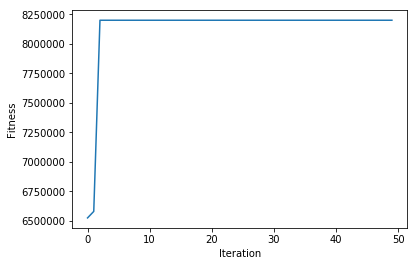

In [34]:
# 参数定义，模型训练
'''
parent_selection_type = "sss""rws""sus""random""tournament""rank"
crossover_type = "single_point""two_points""uniform"
mutation_type == "random""swap""scramble""inversion"

'''
#function_inputs = [4,-2,3.5,5,-11,-4.7, 9, 3]
#desired_output = 100

num_generations = 50# 遗传代数
sol_per_pop = 100 # 种群染色体数目
num_parents_mating = 10# 在交配池中选择作为父代的染色体数
num_genes = 10 # 基因个数
parent_selection_type = "rank" # sss rank
keep_parents = -1
K_tournament = 3
crossover_type="two_points" # two_points tp
mutation_type="swap" # swap swap
mutation_percent_genes=10 # 基因变异的百分比
mutation_num_genes=1 # 变异的基因个数
random_mutation_min_val=-1.0
random_mutation_max_val=1.0

# 获取list中所有匹配项的index
def get_index(lst=None, item=''):
    return [index for (index,value) in enumerate(lst) if value == item]

#def fitness_func_test(solution_attr):
#    output = np.sum(solution_attr*function_inputs)
#    fitness = 1.0 / np.abs(output - desired_output)
#    return fitness
# 计算单个染色体的适应度
def fitness_func(solution_attr):
    index = np.argwhere(solution_attr==1)
    numj = sum(solution_attr==1) # 充电站的个数
    s_fitness = 0  # 适应度
    for i in index:
        j = i[0]
        car_num_attr = car_num(j, cluster_centroids_final)
        s_fitness += lamda_1[j]/numj*car_num_attr*(tj1[j]+tj2[j])+lamda_2[j]/car_num_attr
    return s_fitness

ga_instance = GA(num_generations=num_generations, 
                 sol_per_pop=sol_per_pop, 
                 num_parents_mating=num_parents_mating, 
                 num_genes=num_genes,
                 fitness_func=fitness_func,
                 mutation_percent_genes=mutation_percent_genes,
                 mutation_num_genes=mutation_num_genes,
                 parent_selection_type=parent_selection_type,
                 crossover_type=crossover_type,
                 mutation_type=mutation_type,
                 keep_parents=keep_parents,
                 K_tournament=3)

ga_instance.run()
ga_instance.plot_result()
ga_instance.save(data_dir+'/ga_instance/ga_instance_'+parent_selection_type+'_'+crossover_type+'_'+mutation_type)

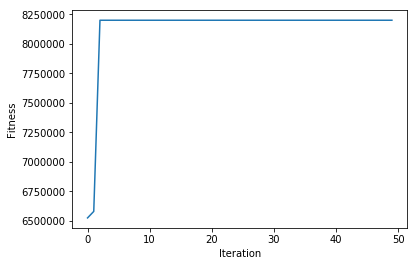

In [35]:
ga_instance.save(data_dir+'/ga_instance/ga_instance_2')
ga_instance.plot_result()

In [36]:
print(ga_instance.best_solution())

[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 0 0 0 0 0 1 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0]
[0 1 0 1 0